In [1]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import StorageLevel

In [2]:
# # Edit based on job info
os.environ['PYSPARK_PYTHON'] = '/home/ann_exx/miniconda3/envs/spark310/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ann_exx/miniconda3/envs/spark310/bin/python'
sc = SparkSession.builder \
    .appName("GDP_Analysis") \
    .master("local[8]") \
    .config("spark.driver.memory", "110g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

# sc = SparkSession.builder \
#     .appName("YourApp") \
#     .master("local[5]") \
#     .config("spark.driver.memory", "110g") \
#     .config("spark.sql.adaptive.enabled", "true") \
#     .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
#     .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/07 00:01:31 WARN Utils: Your hostname, SN4622118450, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/07 00:01:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/07 00:01:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [48]:
import json
import numpy as np
import seaborn as sns
from operator import add
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import (col, regexp_extract, from_unixtime, year, month, quarter, avg, count, when, sum, length, greatest, least, 
    round as spark_round, coalesce, lit, desc, asc, array, explode, monotonically_increasing_id, row_number, stddev_samp, first, pandas_udf,lag, udf)

In [4]:
def get_shape(df):
    return (df.count(), len(df.columns))

In [5]:
base_dir = "/home/ann_exx/232"
essential_files = []
luxury_files = []

# Find files
for pos_json in os.listdir(base_dir):
    if pos_json.endswith('.jsonl'):
        full_path = os.path.join(base_dir, pos_json)
        if "Grocery" in pos_json or "Baby" in pos_json:
            essential_files.append(full_path)
        elif "Movies" in pos_json or "Video" in pos_json:
            luxury_files.append(full_path)
            
# Essential data
if essential_files:
    essential_df = sc.read.json(essential_files)
    essential_df = essential_df.withColumn("product_group", F.lit("essential"))
    # essential_rows, essential_cols = get_shape(essential_df)
    # print(f"Essential DataFrame shape: ({essential_rows}, {essential_cols})")
else:
    print("No essential product files found")
    essential_df = None
    
# Luxury data
if luxury_files:
    luxury_df = sc.read.json(luxury_files)
    luxury_df = luxury_df.withColumn("product_group", F.lit("luxury"))
    # luxury_rows, luxury_cols = get_shape(luxury_df)
    # print(f"Luxury DataFrame shape: ({luxury_rows}, {luxury_cols})")
else:
    print("No luxury product files found")
    luxury_df = None

# Merged data
if essential_df is not None and luxury_df is not None:
    merged_df = essential_df.union(luxury_df)
    # merged_rows, merged_cols = get_shape(merged_df)
    # print(f"Merged DataFrame shape: ({merged_rows}, {merged_cols})")
else:
    print("No files were found and loaded.")
    merged_df = None

In [6]:
merged_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- product_group: string (nullable = false)



In [7]:
nulls = merged_df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
                          for c in merged_df.columns])
nulls.show()

[Stage 2:======================================================>(149 + 1) / 150]

+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|product_group|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|            0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+



In [6]:
# Filter out review that refers to images 
def filter_non_image_text(df, name):
    filtered_df = df.filter(
        col("text").isNotNull() &
        ~(col("text").rlike(r"^\s*(\[image\]|\(image\)|image only|just a picture|no text)") | col("text").rlike(r"^\s*$") |  
          (col("images").isNotNull() & col("text").rlike(r"^\s*[0-9]+\s*$")))) 
    
    # original_count = df.count()
    filtered_count = filtered_df.count()
    # print(f"{name} - Original row count: {original_count}")
    print(f"{name} - Filtered row count: {filtered_count}")
    
    return filtered_df

dataframes_to_process = [(essential_df, "Essential"),(luxury_df, "Luxury"),(merged_df, "Merged")]
# dataframes_to_process = [(essential_df, "Essential")]

cleaned_df = {}
for df, name in dataframes_to_process:
        cleaned_df[name.lower()] = filter_non_image_text(df, name)


Essential - Filtered row count: 20323459


Luxury - Filtered row count: 21946745


[Stage 8:======================================================>(148 + 2) / 150]

Merged - Filtered row count: 42270204


In [9]:
cleaned_df["merged"] = cleaned_df["merged"].withColumn("text_len", length("text"))
cleaned_df["merged"].select("text_len").describe().show()

[Stage 14:=====================================================>(148 + 2) / 150]

+-------+------------------+
|summary|          text_len|
+-------+------------------+
|  count|          42270204|
|   mean|212.53295718657995|
| stddev|442.69071854238047|
|    min|                 1|
|    max|             36893|
+-------+------------------+



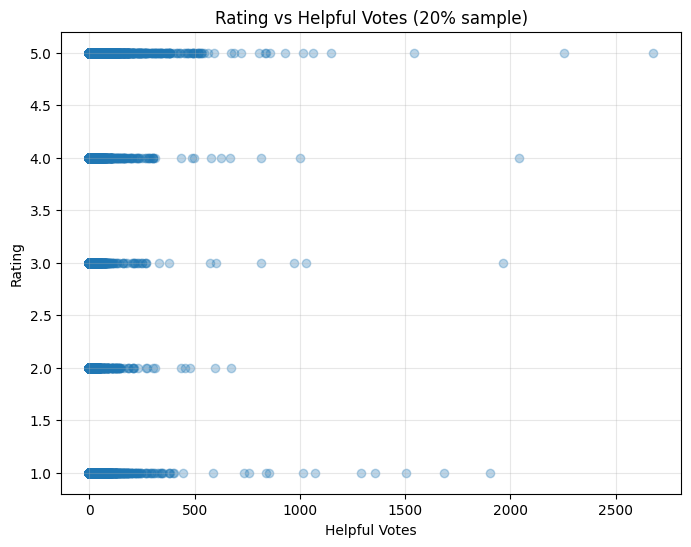

In [10]:
# Sample the data & plot helpful votes
rdd = cleaned_df["merged"].select("helpful_vote", "rating").sample(0.02, seed=42).rdd.map(lambda r: (r["helpful_vote"], r["rating"]))

data = rdd.collect()
helpful_votes, ratings = zip(*data)

plt.figure(figsize=(8, 6))
plt.scatter(helpful_votes, ratings, alpha=0.3)
plt.xlabel("Helpful Votes")
plt.ylabel("Rating")
plt.title("Rating vs Helpful Votes (20% sample)")
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Convert time & only keep relevant columns
def prepare_df_for_analysis(df, name):
        analysis_df = df.withColumn("parsed_time", from_unixtime(col("timestamp")/1000)).withColumn(
            "year", year(col("parsed_time"))).select("asin", "text", "rating", "year", "product_group")

        print(f"\n{name} DataFrame:")
        analysis_df.show(3)
        
        return analysis_df

analysis_df = {}
for name, df in cleaned_df.items():
    analysis_df[name] = prepare_df_for_analysis(df, name.capitalize())
    


Essential DataFrame:
+----------+--------------------+------+----+-------------+
|      asin|                text|rating|year|product_group|
+----------+--------------------+------+----+-------------+
|B004FM7VOW|I bought two of t...|   4.0|2016|    essential|
|B01E5E703G|LOVE THESE! AND T...|   5.0|2016|    essential|
|B00F463XV8|cute but small an...|   1.0|2016|    essential|
+----------+--------------------+------+----+-------------+
only showing top 3 rows

Luxury DataFrame:
+----------+--------------------+------+----+-------------+
|      asin|                text|rating|year|product_group|
+----------+--------------------+------+----+-------------+
|B07DJWBYKP|I’m playing on ps...|   4.0|2020|       luxury|
|B00ZS80PC2|Nostalgic fun.  A...|   5.0|2020|       luxury|
|B01FEHJYUU|This was an order...|   5.0|2017|       luxury|
+----------+--------------------+------+----+-------------+
only showing top 3 rows

Merged DataFrame:
+----------+--------------------+------+----+-------

In [12]:
print("\nOverall average rating by product group:")
analysis_df['merged'].groupBy("product_group").agg(avg("rating").alias("avg_rating"),
                                                       count("rating").alias("count")).show()


Overall average rating by product group:


[Stage 21:=====================================================>(149 + 1) / 150]

+-------------+-----------------+--------+
|product_group|       avg_rating|   count|
+-------------+-----------------+--------+
|    essential|4.149866860754362|20323459|
|       luxury|4.204117330383162|21946745|
+-------------+-----------------+--------+



In [13]:
def analyze_ratings_by_year(df, name):
    rating_counts_by_year = df.groupBy("year", "rating").count().orderBy("year", "rating")
    print(f"\n{name} - Rating counts by year and rating:")
    rating_counts_by_year.show(3)
    
    rating_pivot = df.groupBy("year").pivot("rating", [1.0, 2.0, 3.0, 4.0, 5.0]).count().fillna(0).orderBy("year")
    print(f"\n{name} - Rating pivot table:")
    rating_pivot.show(3)
    
    # Convert to RDD for plots
    rating_count_rdd = rating_pivot.select("year", "`1.0`", "`2.0`", "`3.0`", "`4.0`", "`5.0`").rdd.map(
        lambda r: (r["year"], r["1.0"] or 0, r["2.0"] or 0, r["3.0"] or 0, r["4.0"] or 0, r["5.0"] or 0))
    data = rating_count_rdd.collect()
    
    if data:
        years, one_star, two_star, three_star, four_star, five_star = zip(*data)
        print(f"\n Years analyzed: {list(years)}")
        
        return rating_pivot, data

results = {}
for name, df in analysis_df.items():
    pivot_table, rating_data = analyze_ratings_by_year(df, name.capitalize())
    results[name] = {'pivot_table': pivot_table,'rating_data': rating_data}


Essential - Rating counts by year and rating:


+----+------+-----+
|year|rating|count|
+----+------+-----+
|2000|   3.0|    1|
|2000|   4.0|    5|
|2000|   5.0|    8|
+----+------+-----+
only showing top 3 rows

Essential - Rating pivot table:


+----+---+---+---+---+---+
|year|1.0|2.0|3.0|4.0|5.0|
+----+---+---+---+---+---+
|2000|  0|  0|  1|  5|  8|
|2001| 28| 16| 19| 36|117|
|2002|161| 85| 94|199|482|
+----+---+---+---+---+---+
only showing top 3 rows



 Years analyzed: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Luxury - Rating counts by year and rating:


+----+------+-----+
|year|rating|count|
+----+------+-----+
|1997|   2.0|    1|
|1997|   3.0|    1|
|1997|   4.0|    4|
+----+------+-----+
only showing top 3 rows

Luxury - Rating pivot table:


+----+----+---+----+----+-----+
|year| 1.0|2.0| 3.0| 4.0|  5.0|
+----+----+---+----+----+-----+
|1997|   0|  1|   1|   4|   27|
|1998|  62| 54|  95| 276| 1002|
|1999|1057|717|1333|2822|10063|
+----+----+---+----+----+-----+
only showing top 3 rows



 Years analyzed: [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Merged - Rating counts by year and rating:


+----+------+-----+
|year|rating|count|
+----+------+-----+
|1997|   2.0|    1|
|1997|   3.0|    1|
|1997|   4.0|    4|
+----+------+-----+
only showing top 3 rows

Merged - Rating pivot table:


+----+----+---+----+----+-----+
|year| 1.0|2.0| 3.0| 4.0|  5.0|
+----+----+---+----+----+-----+
|1997|   0|  1|   1|   4|   27|
|1998|  62| 54|  95| 276| 1002|
|1999|1057|717|1333|2822|10063|
+----+----+---+----+----+-----+
only showing top 3 rows


[Stage 77:=====================================================>(149 + 1) / 150]


 Years analyzed: [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [14]:
# Average ratings for products by years

essential_avg = analysis_df['essential'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nEssential Products - Average rating by year:")
essential_avg.show(5)

luxury_avg = analysis_df['luxury'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nLuxury Products - Average rating by year:")
luxury_avg.show(5)

merged_avg = analysis_df['merged'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nMerged Products - Average rating by year:")
merged_avg.show(5)


Essential Products - Average rating by year:


+----+------------------+
|year|        avg_rating|
+----+------------------+
|2000|               4.5|
|2001|3.9166666666666665|
|2002|3.7404505386875613|
|2003| 3.937769562538509|
|2004|3.8288962010170504|
+----+------------------+
only showing top 5 rows

Luxury Products - Average rating by year:


+----+------------------+
|year|        avg_rating|
+----+------------------+
|1997|4.7272727272727275|
|1998| 4.411685695097381|
|1999| 4.257941470735368|
|2000| 4.128990877993158|
|2001| 4.065049492465796|
+----+------------------+
only showing top 5 rows

Merged Products - Average rating by year:


[Stage 96:=====================================================>(149 + 1) / 150]

+----+------------------+
|year|        avg_rating|
+----+------------------+
|1997|4.7272727272727275|
|1998| 4.411685695097381|
|1999| 4.257941470735368|
|2000| 4.129083395675252|
|2001|  4.06454602576186|
+----+------------------+
only showing top 5 rows


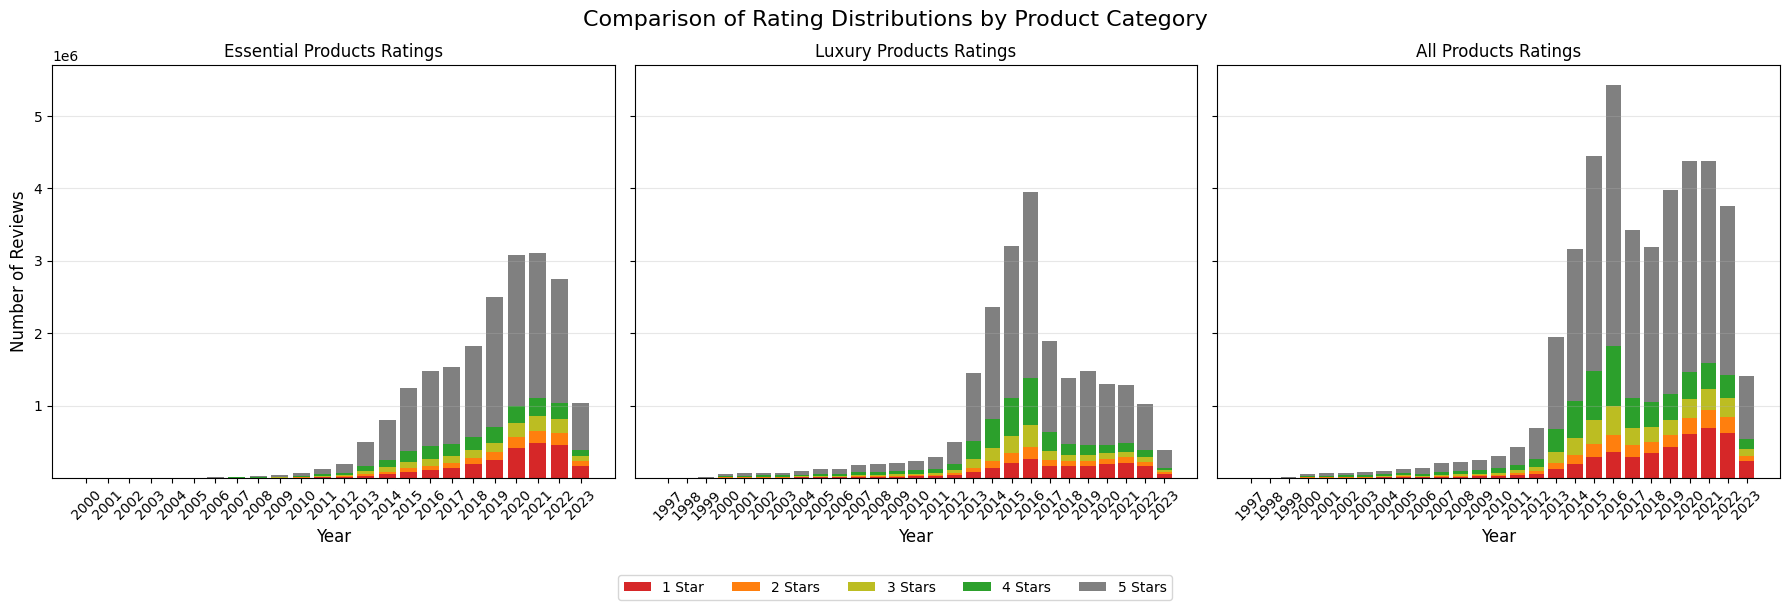

In [15]:
# Review distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plots_data = [
    {"data": results['essential']['rating_data'], "title": "Essential Products", "ax": axes[0]},
    {"data": results['luxury']['rating_data'], "title": "Luxury Products", "ax": axes[1]},
    {"data": results['merged']['rating_data'], "title": "All Products", "ax": axes[2]}]
    
colors = ['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', 'gray']
labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
    
# Create each subplot
for plot in plots_data:
    data = plot["data"]
    ax = plot["ax"]
    title = plot["title"]
        
    years, one_star, two_star, three_star, four_star, five_star = zip(*data)
    bar_width = 0.8
    bottom = [0] * len(years)
    ratings_data = [one_star, two_star, three_star, four_star, five_star]
        
    for i, (rating_data, color, label) in enumerate(zip(ratings_data, colors, labels)):
        if plot == plots_data[0]:
            ax.bar(years, rating_data, bar_width, bottom=bottom, label=label, color=color) # Only add label to the first plot

        else:
            ax.bar(years, rating_data, bar_width, bottom=bottom, color=color)
        bottom = [b + r for b, r in zip(bottom, rating_data)]
        
    ax.set_xlabel('Year', fontsize=12)
    if plot == plots_data[0]:  
        ax.set_ylabel('Number of Reviews', fontsize=12) # Only add y-label to the first subplot
    ax.set_title(f'{title} Ratings', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  
plt.suptitle('Comparison of Rating Distributions by Product Category', fontsize=16)
plt.subplots_adjust(bottom=0.2)  
plt.show()



In [16]:
def calculate_yearly_stats(df, name):
    yearly_avg_ratings = df.groupBy("year").agg(avg("rating").alias("avg_rating"),count("*").alias(
        "review_count")).orderBy("year")
    print(f"\n{name} - Yearly average ratings:")
    yearly_avg_ratings.show(5)
    
    yearly_stats = yearly_avg_ratings.collect()
    years = [row['year'] for row in yearly_stats]
    avg_ratings = [row['avg_rating'] for row in yearly_stats]
    review_counts = [row['review_count'] for row in yearly_stats]
    
    return {'years': years,'avg_ratings': avg_ratings,'review_counts': review_counts,'dataframe': yearly_avg_ratings}

yearly_stats = {}

for name, df in analysis_df.items():
    yearly_stats[name] = calculate_yearly_stats(df, name.capitalize())



Essential - Yearly average ratings:


+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|2000|               4.5|          14|
|2001|3.9166666666666665|         216|
|2002|3.7404505386875613|        1021|
|2003| 3.937769562538509|        1623|
|2004|3.8288962010170504|        3343|
+----+------------------+------------+
only showing top 5 rows



Luxury - Yearly average ratings:


+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|1997|4.7272727272727275|          33|
|1998| 4.411685695097381|        1489|
|1999| 4.257941470735368|       15992|
|2000| 4.128990877993158|       56128|
|2001| 4.065049492465796|       63444|
+----+------------------+------------+
only showing top 5 rows



Merged - Yearly average ratings:


+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|1997|4.7272727272727275|          33|
|1998| 4.411685695097381|        1489|
|1999| 4.257941470735368|       15992|
|2000| 4.129083395675252|       56142|
|2001|  4.06454602576186|       63660|
+----+------------------+------------+
only showing top 5 rows


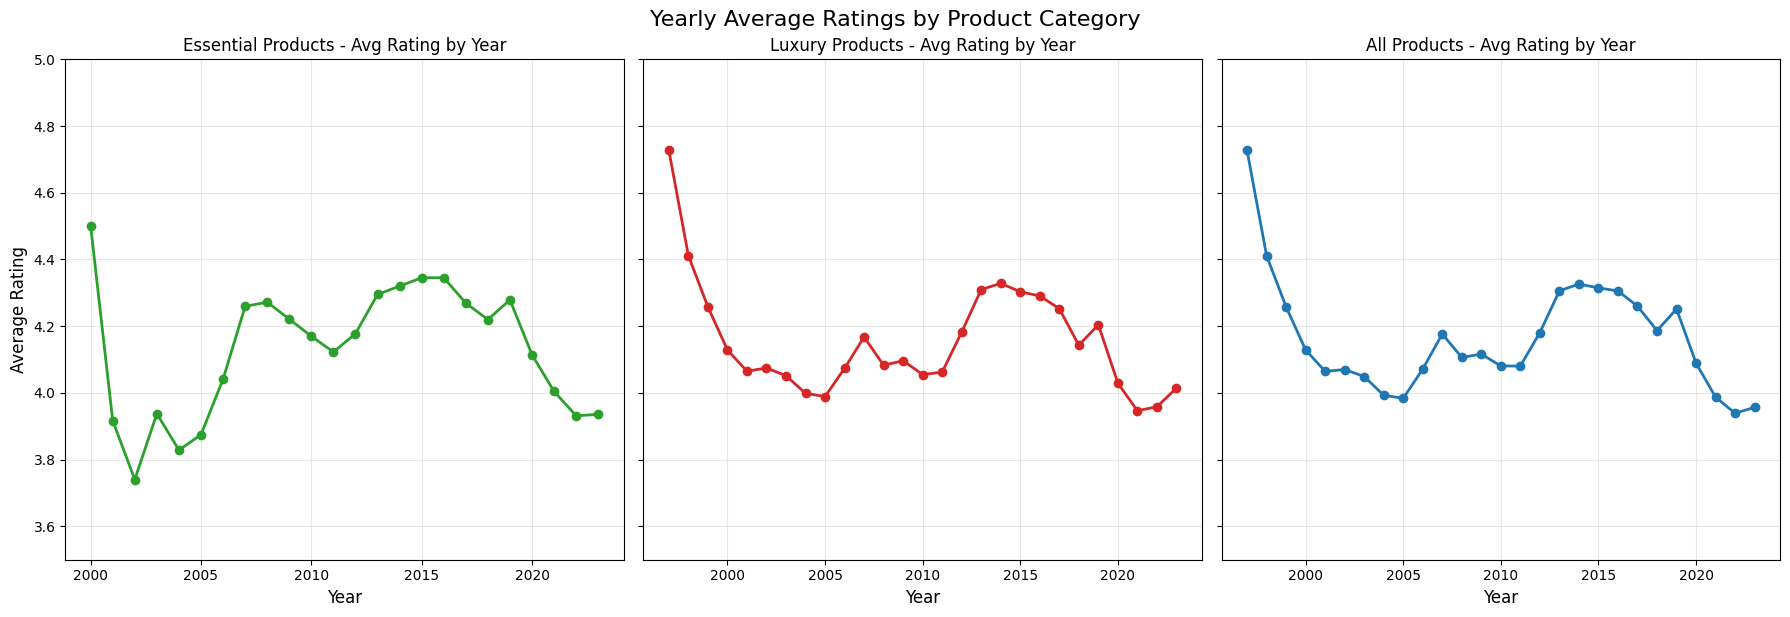

In [17]:
# Yearly average rating plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot essential products
essential_data = yearly_stats['essential']
axes[0].plot(essential_data['years'], essential_data['avg_ratings'], 'o-', color='#2ca02c', linewidth=2)
axes[0].set_title('Essential Products - Avg Rating by Year', fontsize=12)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(3.5, 5.0)


# Plot luxury products
luxury_data = yearly_stats['luxury']
axes[1].plot(luxury_data['years'], luxury_data['avg_ratings'], 'o-', color='#d62728', linewidth=2)
axes[1].set_title('Luxury Products - Avg Rating by Year', fontsize=12)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(3.5, 5.0)
# Add value lab

# Plot merged products
merged_data = yearly_stats['merged']
axes[2].plot(merged_data['years'], merged_data['avg_ratings'], 'o-', color='#1f77b4', linewidth=2)
axes[2].set_title('All Products - Avg Rating by Year', fontsize=12)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(3.5, 5.0)

plt.tight_layout()
plt.suptitle('Yearly Average Ratings by Product Category', fontsize=16, y=1.02)
plt.show()


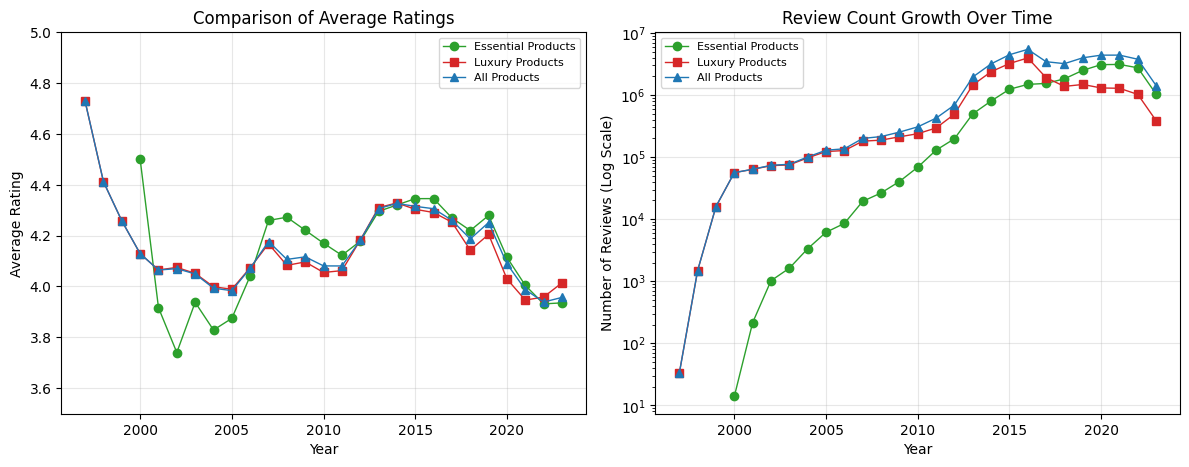

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Combine avg rating plots
ax1.plot(essential_data['years'], essential_data['avg_ratings'], 'o-', color='#2ca02c', linewidth=1, label='Essential Products')
ax1.plot(luxury_data['years'], luxury_data['avg_ratings'], 's-', color='#d62728', linewidth=1, label='Luxury Products')
ax1.plot(merged_data['years'], merged_data['avg_ratings'], '^-', color='#1f77b4', linewidth=1, label='All Products')
ax1.set_title('Comparison of Average Ratings', fontsize=12)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Average Rating', fontsize=10)
ax1.set_ylim(3.5, 5.0)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8)

# Review growth plot
ax2.semilogy(essential_data['years'], essential_data['review_counts'], 'o-', color='#2ca02c', linewidth=1, label='Essential Products')
ax2.semilogy(luxury_data['years'], luxury_data['review_counts'], 's-', color='#d62728', linewidth=1, label='Luxury Products')
ax2.semilogy(merged_data['years'], merged_data['review_counts'], '^-', color='#1f77b4', linewidth=1, label='All Products')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Number of Reviews (Log Scale)', fontsize=10)
ax2.set_title('Review Count Growth Over Time', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## GDP Data ##

In [8]:
!gdown "https://drive.google.com/uc?id=1vkgO0QrsPUuJ4-aPPLdJMsBdDRKlm-Hn"

Downloading...
From: https://drive.google.com/uc?id=1vkgO0QrsPUuJ4-aPPLdJMsBdDRKlm-Hn
To: /home/ann_exx/232/GDP_perCapita.csv
100%|████████████████████████████████████████| 191k/191k [00:00<00:00, 3.56MB/s]


In [9]:
sc.conf.set("spark.sql.debug.maxToStringFields", "100")
years_to_drop = [str(year) for year in range(1960, 1995)] + ["Unnamed: 69", "2024"]

gdp_df = sc.read.option("header", "true").csv("GDP_perCapita.csv")
US_gdp = gdp_df.filter(gdp_df["Country Name"] == "United States").drop(*years_to_drop)
US_gdp.select([count(when(col(c).isNull(), c)).alias(c) for c in US_gdp.columns]).show()

+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|           0|           0|             0|             0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-

In [10]:
year_columns = gdp_df.columns[4:]
for year in year_columns:
    gdp_df = gdp_df.withColumn(year, col(year).cast("double"))

max_col = greatest(*[col(year) for year in year_columns])
min_col = least(*[col(year) for year in year_columns])
sum_expr = reduce(add, [col(year) for year in year_columns])  # Correct summation

gdp_stat = gdp_df.select(max_col.alias("max_gdp"), min_col.alias("min_gdp"), (sum_expr / len(year_columns)).alias("avg_gdp"))

s1 = gdp_stat.collect()[0]
print(f"GDP Stats - Max: {s1['max_gdp']}, Min: {s1['min_gdp']}, Avg: {s1['avg_gdp']}")

GDP Stats - Max: 25.15496385, Min: -25.79322999, Avg: None


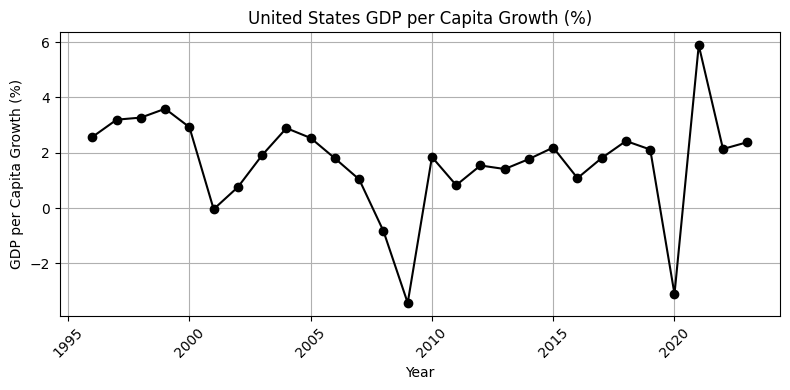

In [11]:
gdp_pd = US_gdp.select([str(year) for year in range(1996, 2024)]).toPandas().iloc[0].astype(float).values
years = list(range(1996, 2024))

# Plot GDP
plt.figure(figsize=(8, 4))
plt.plot(years, gdp_pd, marker='o', linestyle='-', color='black')
plt.title("United States GDP per Capita Growth (%)")
plt.xlabel("Year")
plt.ylabel("GDP per Capita Growth (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
all_columns = US_gdp.columns
year_columns = [col_name for col_name in all_columns if col_name.isdigit() and 1990 <= int(col_name) <= 2030]
        
year_value_pairs = []
    
for year_col in year_columns:
    year_df = US_gdp.select(lit(int(year_col)).alias("year"),col(year_col).alias("gdp_value"))
    year_value_pairs.append(year_df)
    
if year_value_pairs:
    long_format_df = year_value_pairs[0]
    for df_part in year_value_pairs[1:]:
        long_format_df = long_format_df.union(df_part)
else:
    raise ValueError("No year columns found in the DataFrame")
    
long_df = long_format_df.filter(col("gdp_value").isNotNull()).orderBy("year")

In [13]:
def calculate_pct_change(long_df):
    data = long_df.orderBy("year").collect()
    
    results = []
    for i, row in enumerate(data):
        year = row['year']
        current_gdp = float(row['gdp_value'])
        
        if i == 0:  # First year
            gdp_change = None
            gdp_change_pct = None
            gdp_label = None  
        else:
            previous_gdp = float(data[i-1]['gdp_value'])
            gdp_change = current_gdp - previous_gdp
            gdp_change_pct = (gdp_change / previous_gdp) * 100
            gdp_label = 1 if gdp_change > 0 else 0
        
        results.append((year, current_gdp, gdp_change, gdp_change_pct, gdp_label))

    schema = StructType([
        StructField("year", IntegerType(), True),
        StructField("gdp_value", DoubleType(), True),
        StructField("gdp_change", DoubleType(), True),
        StructField("gdp_change_pct", DoubleType(), True),
        StructField("gdp_label", IntegerType(), True)])
    
    result_df = sc.createDataFrame(results, schema)
    return result_df

result_df = calculate_pct_change(long_df)

display_df = result_df.select(
        col("year"),
        spark_round(col("gdp_value"), 3).alias("gdp_value"),
        spark_round(col("gdp_change"), 3).alias("gdp_change"), 
        spark_round(col("gdp_change_pct"), 2).alias("gdp_change_pct"),
        col("GDP_label"))
    
display_df.show(50, truncate=False)

+----+---------+----------+--------------+---------+
|year|gdp_value|gdp_change|gdp_change_pct|GDP_label|
+----+---------+----------+--------------+---------+
|1995|1.469    |NULL      |NULL          |NULL     |
|1996|2.572    |1.104     |75.13         |1        |
|1997|3.197    |0.625     |24.28         |1        |
|1998|3.272    |0.075     |2.35          |1        |
|1999|3.592    |0.32      |9.77          |1        |
|2000|2.926    |-0.666    |-18.54        |0        |
|2001|-0.039   |-2.965    |-101.32       |0        |
|2002|0.761    |0.8       |-2065.4       |1        |
|2003|1.916    |1.155     |151.68        |1        |
|2004|2.891    |0.975     |50.9          |1        |
|2005|2.534    |-0.357    |-12.35        |0        |
|2006|1.798    |-0.736    |-29.04        |0        |
|2007|1.038    |-0.76     |-42.26        |0        |
|2008|-0.829   |-1.867    |-179.83       |0        |
|2009|-3.427   |-2.598    |313.43        |0        |
|2010|1.847    |5.274     |-153.89       |1   

## Sentiment Analysis ##

In [14]:
df = analysis_df['merged']

# Year-over-year Sentiment Change #

In [44]:
import re
import pandas as pd
from wordcloud import WordCloud
from textblob import TextBlob
from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.sql.window import Window
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler, PCA, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


[Stage 4919:==========> (128 + 8) / 150][Stage 4920:>             (0 + 0) / 150]

In [16]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])


[Stage 4936:>             (6 + 8) / 150][Stage 4937:>             (0 + 0) / 150]]

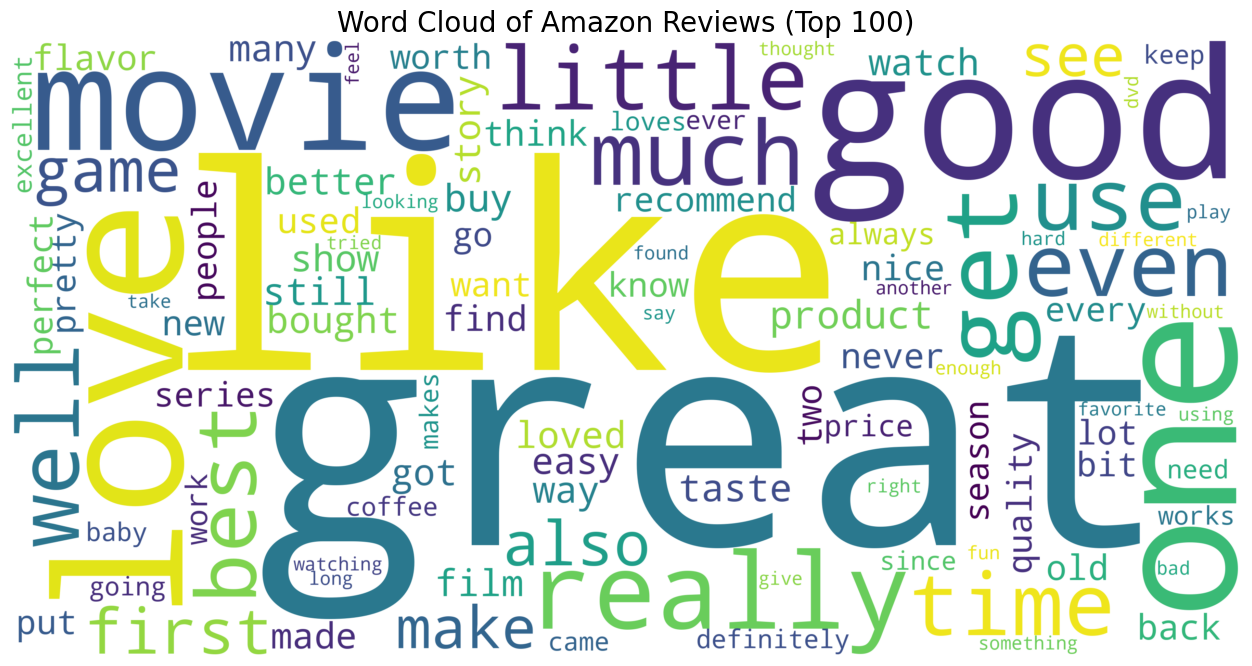

[Stage 4936:==>          (32 + 8) / 150][Stage 4937:>             (0 + 0) / 150]

In [49]:
wc_df = Pipeline(stages=[tokenizer, remover]).fit(df).transform(df)

@udf(ArrayType(StringType()))
def keep_alpha(tokens):
    return [w for w in tokens if re.fullmatch(r"[A-Za-z]{2,}", w)]

wc_df = wc_df.withColumn("filtered_words", keep_alpha(col("filtered_words")))

# Flatten + count
word_counts = (wc_df.select("filtered_words").rdd.flatMap(lambda r: r.filtered_words).map(lambda w: (w, 1)).reduceByKey(lambda a, b: a + b))

top_tokens = word_counts.takeOrdered(100, key=lambda x: -x[1])
freq_dict  = dict(top_tokens)

# Render high-res cloud
wc = WordCloud(
    width=1200, height=600, scale=3,
    max_words=100, max_font_size=300,
    background_color="white", colormap="viridis").generate_from_frequencies(freq_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Amazon Reviews (Top 100)", fontsize=20)
plt.show()

In [17]:
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
model = pipeline.fit(df)
tfidf_df = model.transform(df)

In [18]:
@pandas_udf(returnType=DoubleType())
def polarity_pandas_udf(texts: pd.Series) -> pd.Series:
    def get_polarity(text):
        if pd.isna(text):
            return None
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return None
    return texts.apply(get_polarity)

df_with_polarity = tfidf_df.withColumn("polarity_score", polarity_pandas_udf(col("text")))
df_with_polarity.show(5)


[Stage 29:>                                                         (0 + 1) / 1]

+----------+--------------------+------+----+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|      asin|                text|rating|year|product_group|               words|      filtered_words|         rawFeatures|            features|     polarity_score|
+----------+--------------------+------+----+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|B004FM7VOW|I bought two of t...|   4.0|2016|    essential|[i, bought, two, ...|[bought, two, kid...|(5000,[88,133,157...|(5000,[88,133,157...|0.07516684704184703|
|B01E5E703G|LOVE THESE! AND T...|   5.0|2016|    essential|[love, these!, an...|[love, these!, wo...|(5000,[44,125,150...|(5000,[44,125,150...|0.42997835497835496|
|B00F463XV8|cute but small an...|   1.0|2016|    essential|[cute, but, small...|[cute, small, pre...|(5000,[222,349,41...|(5000,[222,349,41...|0.19999999999999998|
|B0007V644S|I ha

In [19]:
combined_df = df_with_polarity.withColumn("polarity_score", polarity_pandas_udf(col("text"))) \
                     .withColumn("label_rating", when(col("rating") >= 4, 1.0).when(col("rating") <= 2, 0.0).otherwise(None))
binary_df = combined_df.filter(col("label_rating").isNotNull() & col("polarity_score").isNotNull())


assembler = VectorAssembler(inputCols=["features", "polarity_score"], outputCol="combined_features")
modeling_df = assembler.transform(binary_df)             

In [20]:
modeling_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- text: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_group: string (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- polarity_score: double (nullable = true)
 |-- label_rating: double (nullable = true)
 |-- combined_features: vector (nullable = true)



In [21]:
tfidf_by_year = modeling_df.groupBy("year", "product_group").agg(Summarizer.mean(col("features")).alias("avg_tfidf_features"))
tfidf_pivot = tfidf_by_year.groupBy("year").pivot("product_group").agg(first("avg_tfidf_features"))
tfidf_pivot = tfidf_pivot.withColumnRenamed("essential", "essential_tfidf").withColumnRenamed("luxury", "luxury_tfidf")
tfidf_pivot.show(5)

[Stage 38:=====================================================>(149 + 1) / 150]

+----+--------------------+--------------------+
|year|     essential_tfidf|        luxury_tfidf|
+----+--------------------+--------------------+
|1997|                NULL|[0.0,0.0,0.504466...|
|1998|                NULL|[0.02102268613324...|
|1999|                NULL|[0.02249050244113...|
|2000|[0.0,0.3821773535...|[0.03554174389435...|
|2001|[0.0,0.0504396507...|[0.04142220324451...|
+----+--------------------+--------------------+
only showing top 5 rows


In [22]:
yearly_sentiment = modeling_df.groupBy("year", "product_group") \
    .agg(avg("polarity_score").alias("avg_sentiment"), count("*").alias("review_count"), stddev_samp("polarity_score").alias("sentiment_volatility"))

sentiment_features = yearly_sentiment.groupBy("year").pivot("product_group") \
    .agg(first("avg_sentiment").alias("avg_sentiment"), first("review_count").alias("review_count"), first("sentiment_volatility").alias("volatility"))

sentiment_features.show()

[Stage 52:=====================================================>(149 + 1) / 150]

+----+-----------------------+----------------------+--------------------+--------------------+-------------------+-------------------+
|year|essential_avg_sentiment|essential_review_count|essential_volatility|luxury_avg_sentiment|luxury_review_count|  luxury_volatility|
+----+-----------------------+----------------------+--------------------+--------------------+-------------------+-------------------+
|2003|    0.18956742015998734|                  1491| 0.17802815705167233| 0.18057992317357383|              66579| 0.1847836261186961|
|2007|     0.2632359431611227|                 17928| 0.22531983692877727| 0.22832437933152244|             162872| 0.2182179621794059|
|2018|    0.34468862301628667|               1704502|  0.3473956498804126|  0.3160092939507984|            1286824| 0.3562639113398816|
|2015|     0.3749109259940206|               1151681|  0.3398860260772828|  0.3822434893927214|            2968672|0.36638094856205505|
|2023|    0.26364630443888004|                95

In [23]:
gdp_sentiment_data = sentiment_features.join(result_df.select("year", "gdp_change_pct", "gdp_label"), on="year", how="inner")

# Add difference between two product groups
combine_gdp = gdp_sentiment_data.withColumn("sentiment_gap", col("essential_avg_sentiment") - col("luxury_avg_sentiment"))

clean_gdp = combine_gdp.filter(col("essential_avg_sentiment").isNotNull())
clean_gdp.show(5)

[Stage 59:=====================================================>(149 + 1) / 150]

+----+-----------------------+----------------------+--------------------+--------------------+-------------------+-------------------+-------------------+---------+--------------------+
|year|essential_avg_sentiment|essential_review_count|essential_volatility|luxury_avg_sentiment|luxury_review_count|  luxury_volatility|     gdp_change_pct|gdp_label|       sentiment_gap|
+----+-----------------------+----------------------+--------------------+--------------------+-------------------+-------------------+-------------------+---------+--------------------+
|2000|     0.1617794561208023|                    13|  0.1553086378066472| 0.20981608756483375|              50297|0.19008990515471308|-18.544584404742533|        0|-0.04803663144403145|
|2003|    0.18956742015998734|                  1491| 0.17802815705167233| 0.18057992317357383|              66579| 0.1847836261186961| 151.68020576639108|        1|0.008987496986413518|
|2001|    0.19071656516635782|                   197| 0.187607272

In [24]:
combined_features = clean_gdp.join(tfidf_pivot, on="year", how="inner")

In [25]:
# Reduce TF-IDF dimension for CrossVal
pca_essential = PCA(k=50, inputCol="essential_tfidf", outputCol="essential_pca")
pca_luxury = PCA(k=50, inputCol="luxury_tfidf", outputCol="luxury_pca")

pca_model_essential = pca_essential.fit(combined_features)
pca_model_luxury = pca_luxury.fit(combined_features)

reduced_features = pca_model_essential.transform(combined_features)
reduced_features = pca_model_luxury.transform(reduced_features)

In [27]:
window_yoy = Window.partitionBy().orderBy("year")

yoy_data = reduced_features \
    .withColumn("essential_sentiment_yoy_change", col("essential_avg_sentiment") - lag("essential_avg_sentiment", 1).over(window_yoy)) \
    .withColumn("luxury_sentiment_yoy_change", col("luxury_avg_sentiment") - lag("luxury_avg_sentiment", 1).over(window_yoy)) \
    .withColumn("sentiment_gap_yoy_change", col("sentiment_gap") - lag("sentiment_gap", 1).over(window_yoy))

clean_df = yoy_data.filter(
    col("essential_sentiment_yoy_change").isNotNull() & col("luxury_sentiment_yoy_change").isNotNull() & col("sentiment_gap_yoy_change").isNotNull())


In [28]:
final_assembler = VectorAssembler(
    inputCols=[
        "essential_sentiment_yoy_change",
        "luxury_sentiment_yoy_change",
        "sentiment_gap_yoy_change",
        "essential_pca",
        "luxury_pca"], outputCol="features")

final_df = final_assembler.transform(clean_df)

In [31]:
sc.sparkContext.setLogLevel("ERROR")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_df)
scaled_df = scaler_model.transform(final_df)

train = scaled_df.filter(col("year") <= 2018)
test = scaled_df.filter(col("year") > 2018)

In [32]:
#AUC Eval
auc_evaluator = BinaryClassificationEvaluator(labelCol="gdp_label")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="gdp_label", predictionCol="prediction", metricName="accuracy")

gdp_lr = LogisticRegression(featuresCol="scaled_features", labelCol="gdp_label", regParam=0.01, maxIter=10, elasticNetParam=1.0)


In [42]:
paramGrid = ParamGridBuilder().addGrid(gdp_lr.regParam, [0.01, 0.1, 1.0]).addGrid(gdp_lr.maxIter, [10, 30]).build()

sc.sparkContext.setLogLevel("ERROR")

# Cross-validation
crossval = CrossValidator(
    estimator=gdp_lr,
    estimatorParamMaps=paramGrid,
    evaluator=auc_evaluator,
    numFolds=3,
    seed=42,
    parallelism=4)

cv_model = crossval.fit(train)

print(f"\nCROSS-VALIDATION RESULTS")
print("RegParam | MaxIter | CV AUC")
for params, avg_metric in zip(paramGrid, cv_model.avgMetrics):
    print(f"{params[gdp_lr.regParam]:8.2f} | {params[gdp_lr.maxIter]:7d} | {avg_metric:.4f}")


[Stage 4547:===========>(143 + 7) / 150][Stage 4551:==========>    (7 + 1) / 10]


CROSS-VALIDATION RESULTS
RegParam | MaxIter | CV AUC
    0.01 |      10 | 0.2333
    0.01 |      30 | 0.2833
    0.10 |      10 | 0.1500
    0.10 |      30 | 0.2250
    1.00 |      10 | 0.5000
    1.00 |      30 | 0.5000


[Stage 4899:========>    (99 + 8) / 150][Stage 4901:>               (0 + 0) / 1]

In [33]:
model = gdp_lr.fit(train)

# Make predictions
test_predictions = model.transform(test)
train_predictions = model.transform(train)

# Evaluate
train_auc = auc_evaluator.evaluate(train_predictions)
test_auc = auc_evaluator.evaluate(test_predictions)
train_acc = accuracy_evaluator.evaluate(train_predictions)
test_acc = accuracy_evaluator.evaluate(test_predictions)

print(f"Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")
print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")


[Stage 338:====================================================>(149 + 1) / 150]

Train AUC: 1.000, Test AUC: 0.833
Train Accuracy: 1.000, Test Accuracy: 0.800


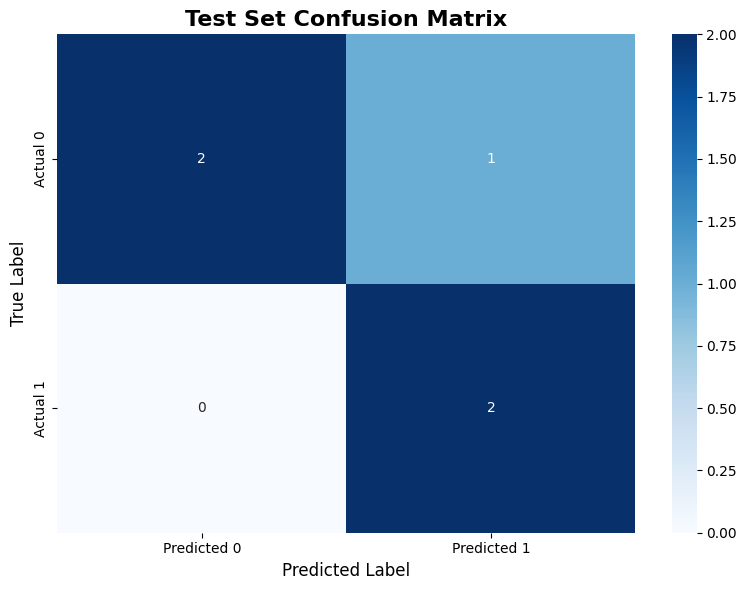

[Stage 4999:>             (8 + 8) / 150][Stage 5000:>             (0 + 0) / 150]

In [52]:
from sklearn.metrics import confusion_matrix

test_labels_predictions = test_predictions.select("gdp_label", "prediction").collect()
y_true = [row.gdp_label for row in test_labels_predictions]
y_pred = [row.prediction for row in test_labels_predictions]

# Cconfusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Test Set Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [39]:
# Linear SVM 
linear_svm = LinearSVC(featuresCol="scaled_features",  labelCol="gdp_label", regParam=0.1, maxIter=100)

svm_model = linear_svm.fit(train)
train_predictions_2 = svm_model.transform(train)
test_predictions_2 = svm_model.transform(test)

train_auc_2 = auc_evaluator.evaluate(train_predictions_2)
test_auc_2 = auc_evaluator.evaluate(test_predictions_2)
train_acc_2 = accuracy_evaluator.evaluate(train_predictions_2)
test_acc_2 = accuracy_evaluator.evaluate(test_predictions_2)

print(f"Linear SVM - Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")
print(f"Linear SVM - Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")

[Stage 3163:===================================================>(149 + 1) / 150]

Linear SVM - Train AUC: 1.000, Test AUC: 0.833
Linear SVM - Train Accuracy: 1.000, Test Accuracy: 0.800
